In [ ]:
# conda create -n PICK python=3.6
# conda install -c conda-forge tesseract 
# conda install gdown
# !pip install opencv-python==4.5.4.58 pandas pytesseract easyocr python-resize-image

#### VOC format (opencv)
- x = xmin
- y = ymin
- w = xmax - xmin
- h = ymax - ymin
-------------------------------
#### YOLO format (normalized)
- x = xmin / width
- y = ymin / height
- w = (xmax - xmin) / width
- h = (ymax - ymin) / height

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
import os
from pathlib import Path
import cv2
import pandas as pd 
import pytesseract
import easyocr
import numpy as np
import csv
import random
from datetime import datetime
import imutils
from resizeimage import resizeimage
from IPython.display import display
try:
    from PIL import Image, ImageEnhance, ImageFilter, ImageDraw, ImageFont
except ImportError:
    import PIL, Image
    
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


### common utilities

In [2]:
def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and grab the image size
    dim = None
    (h, w) = image.shape[:2]
    # if both the width and height are None, then return the original image
    if width is None and height is None:
        return image
    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))
    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)
    # return the resized image
    return resized


def img_2_text(cropped_img):
#     gray_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
#     threshold_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
#     return ' '.join(pytesseract.image_to_string(np.array(threshold_img)).split()).strip()
    return ' '.join(pytesseract.image_to_string(cropped_img).split()).strip()


def draw_boxes(image, bounds, color='green', width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

# FUNSD Dataset:
https://guillaumejaume.github.io/FUNSD/

- dataset
    - training_data (149)
        - annotations
        - images
    - testing_data (50)
        - annotations
            - doc_id.json
        - images
            - doc_id.png

## FUNSD Preprocessing & Visualization

In [3]:
data_path = Path('./funsd_dataset/training_data')
img_path = data_path.joinpath('images')
annot_path = data_path.joinpath('annotations')

# Random ID
img_list = []
for imgs in img_path.glob('*.png'):
    img_list.append(imgs.stem)
    
# pick any doc ID randomly
doc_id = random.choice(img_list)

# if you want to see specific doc ID ELSE just comment
doc_id = '89368010'    # '93329540' 

print(f"Total no. of Images : {len(img_list)}")
print(doc_id)

Total no. of Images : 149
89368010


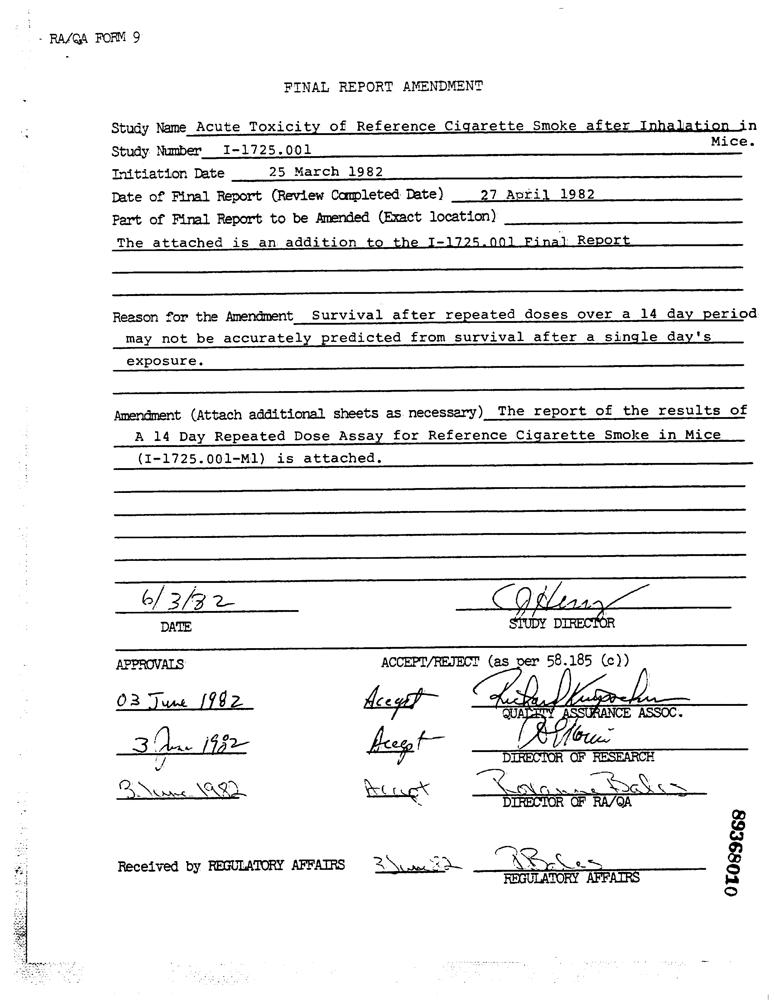

In [4]:
image = Image.open(f"{str(img_path.joinpath(doc_id))}.png")
image = image.convert("RGB")
width, height = image.size
# print(width, height)
image

In [6]:
with open(f"{str(annot_path.joinpath(doc_id))}.json", 'r',  encoding="utf-8") as f:
    data = json.load(f)

for annotation in data['form']:
    print(annotation)

{'box': [154, 618, 197, 636], 'text': 'DATE', 'label': 'question', 'words': [{'box': [154, 618, 197, 636], 'text': 'DATE'}], 'linking': [[0, 1]], 'id': 0}
{'box': [133, 587, 239, 611], 'text': '16/3/82', 'label': 'answer', 'words': [{'box': [133, 587, 239, 611], 'text': '16/3/82'}], 'linking': [[0, 1]], 'id': 1}
{'box': [490, 576, 652, 615], 'text': '', 'label': 'answer', 'words': [{'box': [490, 576, 652, 615], 'text': ''}], 'linking': [[31, 2]], 'id': 2}
{'box': [114, 657, 189, 669], 'text': 'APPROVALS', 'label': 'question', 'words': [{'box': [114, 657, 189, 669], 'text': 'APPROVALS'}], 'linking': [[3, 32], [3, 33], [3, 34]], 'id': 3}
{'box': [364, 684, 442, 709], 'text': 'Accept', 'label': 'answer', 'words': [{'box': [364, 684, 442, 709], 'text': 'Accept'}], 'linking': [[35, 4]], 'id': 4}
{'box': [368, 726, 446, 757], 'text': 'Accept', 'label': 'answer', 'words': [{'box': [368, 726, 446, 757], 'text': 'Accept'}], 'linking': [[35, 5]], 'id': 5}
{'box': [361, 775, 433, 805], 'text': 'A

IMAGE (width,height) : 774, 1000


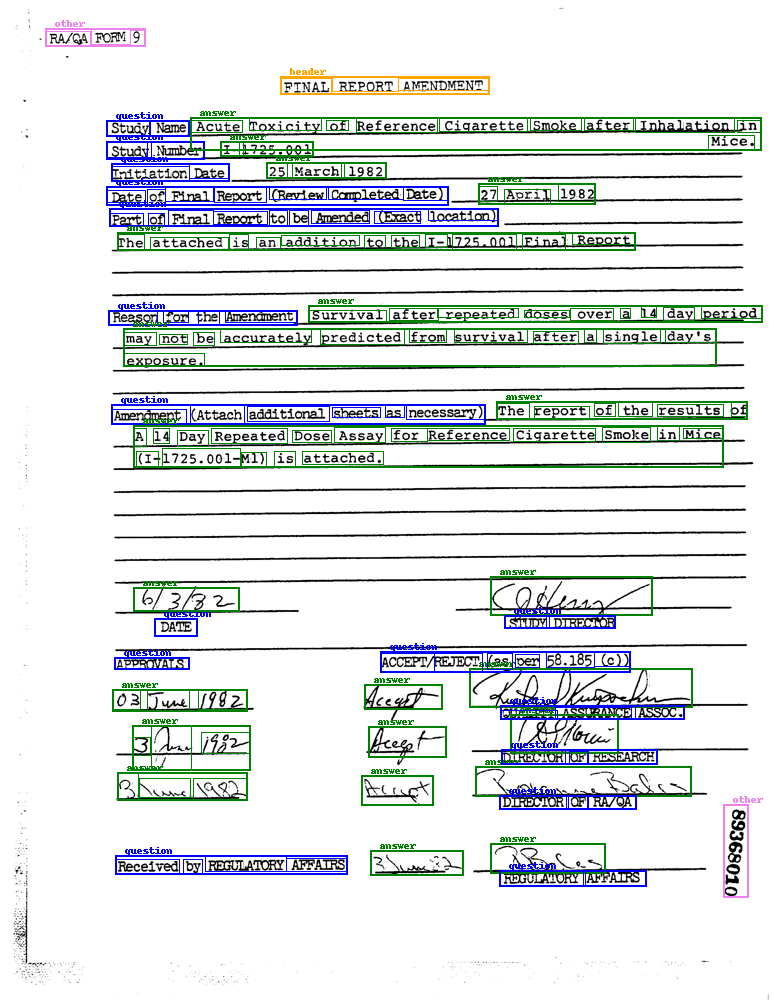

{13: [(45, 28, 145, 46), 'RA/QA FORM 9', 'other'],
 14: [(280, 76, 489, 94), 'FINAL REPORT AMENDMENT', 'header'],
 24: [(190, 117, 761, 150),
  'Acute Toxicity of Reference Cigarette Smoke lafter Inhalation in Mice.',
  'answer'],
 15: [(106, 120, 189, 136), 'Study Name', 'question'],
 16: [(106, 141, 204, 159), 'Study Number', 'question'],
 23: [(220, 141, 313, 156), 'I- 1725.001', 'answer'],
 22: [(266, 162, 386, 178), '25 March 1982', 'answer'],
 17: [(111, 163, 229, 181), 'Initiation Date', 'question'],
 21: [(478, 183, 595, 204), '27 April 1982', 'answer'],
 18: [(106, 186, 448, 205),
  'Date of Final Report (Review Completed Date)',
  'question'],
 19: [(109, 208, 498, 226),
  'Part of Final Report to be Amended (Exact location)',
  'question'],
 20: [(117, 232, 635, 250),
  'The attached is an addition to the I- 1725.001 Final Report',
  'answer'],
 26: [(308, 305, 762, 322),
  'Survival after repeated doses over a 14 day period',
  'answer'],
 25: [(108, 310, 297, 325), 'Reason

In [9]:
# Example contours = [(287, 117, 13, 46), (102, 117, 34, 47), (513, 116, 36, 49), (91, 32, 30, 48), (333, 31, 33, 50)] 
print(f"IMAGE (width,height) : {width}, {height}")


def sort_contour(boundingBoxes, x_axis_sort='LEFT_TO_RIGHT', y_axis_sort='TOP_TO_BOTTOM'):
    # initialize the reverse flag
    x_reverse = False
    y_reverse = False
    if x_axis_sort == 'RIGHT_TO_LEFT':
        x_reverse = True
    if y_axis_sort == 'BOTTOM_TO_TOP':
        y_reverse = True

    boundingBoxes = sorted(boundingBoxes , key=lambda k: [k[1], k[0]], reverse=x_reverse)
    return boundingBoxes


def construct_sorted_lines(line_dict, contours, image_height):
    
    sorted_line_items = dict()
    sorted_contours = sort_contour(contours, x_axis_sort='LEFT_TO_RIGHT', y_axis_sort='TOP_TO_BOTTOM')
    
    for conts in sorted_contours:
        sorted_line_items[line_dict[conts][0]] = [conts, line_dict[conts][1], line_dict[conts][2]]
    return sorted_line_items



draw = ImageDraw.Draw(image, "RGBA")
font = ImageFont.load_default()

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

line_dict = dict()
contours = []
for annotation in data['form']:
    label = annotation['label']
    text = annotation['text']
    general_box = annotation['box']
    draw.rectangle(general_box, outline=label2color[label], width=2)
    draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
    words = annotation['words']
    for word in words:
        box = word['box']
        draw.rectangle(box, outline=label2color[label], width=1)

    if text is not None and len(text)>1:
#         print(f"{annotation['id']},{str(','.join(map(str, general_box)))},{text},{label}")
        line_dict[tuple(general_box)] = [annotation['id'], text, label]
        contours.append(tuple(general_box))
        

display(image)
annotated_lines = construct_sorted_lines(line_dict, contours, height)
annotated_lines

In [10]:
with open(f'{doc_id}.txt') as f:
    lines = [line.rstrip().split(' : ') for line in f]

lines

[['header', 'FINAL REPORT AMENDMENT'],
 ['keys', 'Study Name'],
 ['values',
  'Acute Toxicity of Reference Cigarette Smoke lafter Inhalation in Mice.'],
 ['values', 'I- 1725.001'],
 ['keys', 'Study Number'],
 ['values', '25 March 1982'],
 ['keys', 'Initiation Date'],
 ['values', '27 April 1982'],
 ['keys', 'Date of Final Report (Review Completed Date)'],
 ['keys', 'Part of Final Report to be Amended (Exact location)'],
 ['values', 'The attached is an addition to the I- 1725.001 Final Report'],
 ['values', 'Survival after repeated doses over a 14 day period'],
 ['keys', 'Reason for the Amendment'],
 ['values',
  "may not be accurately predicted from survival after a single day's exposure."],
 ['values', 'The report of the results of'],
 ['keys', 'Amendment (Attach additional sheets as necessary)'],
 ['values',
  'A 14 Day Repeated Dose Assay for Reference Cigarette Smoke in Mice (I- 1725.001- M1 is attached.'],
 ['values', '16/3/82'],
 ['keys', 'STUDY DIRECTOR'],
 ['keys', 'DATE'],
 ['k

In [11]:
keys_to_values = []
values_list = []

data_mapper = dict()

for key, value in annotated_lines.items():
    for i, preds in enumerate(lines):
        if value[1] is preds[1] or value[1] in preds[1]:
            if preds[0] in ['keys', 'values']:
                print(i, value[0], preds[1], preds[0])
                data_mapper[i] = [preds[0], preds[1], value[0]]
                if preds[0] == 'keys':
                    keys_to_values.append([i, value[0]])
                else:
                    values_list.append([i, value[0]])
            break
            

2 (190, 117, 761, 150) Acute Toxicity of Reference Cigarette Smoke lafter Inhalation in Mice. values
1 (106, 120, 189, 136) Study Name keys
4 (106, 141, 204, 159) Study Number keys
3 (220, 141, 313, 156) I- 1725.001 values
5 (266, 162, 386, 178) 25 March 1982 values
6 (111, 163, 229, 181) Initiation Date keys
7 (478, 183, 595, 204) 27 April 1982 values
8 (106, 186, 448, 205) Date of Final Report (Review Completed Date) keys
9 (109, 208, 498, 226) Part of Final Report to be Amended (Exact location) keys
10 (117, 232, 635, 250) The attached is an addition to the I- 1725.001 Final Report values
11 (308, 305, 762, 322) Survival after repeated doses over a 14 day period values
12 (108, 310, 297, 325) Reason for the Amendment keys
13 (123, 328, 716, 366) may not be accurately predicted from survival after a single day's exposure. values
14 (496, 401, 747, 419) The report of the results of values
15 (111, 404, 485, 424) Amendment (Attach additional sheets as necessary) keys
16 (133, 425, 723,

In [12]:
def search_dictionary(search_word, data_map):
    for k, v in data_map.items():
        if v[0] == search_word:
            return k


related_data_map = list()
# temp_dict = data_mapper.copy()

for k, v in data_mapper.copy().items():
    if v[0] == 'keys':
        idx = search_dictionary('values', data_mapper)
        if idx is not None:
#             print(k, idx)
            related_data_map.append({v[1]: data_mapper[idx][1]})
            data_mapper.pop(k)  # del data_mapper[k]
            data_mapper.pop(idx)  # del data_mapper[idx]
        else:
            related_data_map.append({v[1]: 'NA'})
related_data_map

[{'Study Name': 'Acute Toxicity of Reference Cigarette Smoke lafter Inhalation in Mice.'},
 {'Study Number': 'I- 1725.001'},
 {'Initiation Date': '25 March 1982'},
 {'Date of Final Report (Review Completed Date)': '27 April 1982'},
 {'Part of Final Report to be Amended (Exact location)': 'The attached is an addition to the I- 1725.001 Final Report'},
 {'Reason for the Amendment': 'Survival after repeated doses over a 14 day period'},
 {'Amendment (Attach additional sheets as necessary)': "may not be accurately predicted from survival after a single day's exposure."},
 {'STUDY DIRECTOR': 'The report of the results of'},
 {'DATE': 'A 14 Day Repeated Dose Assay for Reference Cigarette Smoke in Mice (I- 1725.001- M1 is attached.'},
 {'ACCEPT/ REJECT (as per 58.185 (c))': '16/3/82'},
 {'APPROVALS': '03 June 1982'},
 {'Accept': 'QUALITY ASSURANCE ASSOC.'},
 {'DIRECTOR OF RESEARCH': 'NA'},
 {'Received by REGULATORY AFFATRS': 'NA'},
 {'REGULATORY AFFAIRS': 'NA'}]

In [ ]:
with open("outcome.json", "w") as outfile:
    json.dump(related_data_map, outfile, ensure_ascii=True, indent=4)

# FUNSD Data Processing

### Create TESTing files

In [ ]:
data_path = Path('./funsd_dataset/testing_data')  # training_data
img_path = data_path.joinpath('images')
annot_path = data_path.joinpath('annotations')

img_list = []
for imgs in img_path.glob('*.png'):
    img_list.append(imgs.stem)

print(f"Total no. of Images : {len(img_list)}")

In [ ]:
boxes_path = data_path.joinpath('boxes_and_transcripts')
boxes_path.mkdir(parents=True, exist_ok=True)

data_loader = list()

for docs_id in img_list:
    try:
        data_map = dict()
        with open(f"{str(annot_path.joinpath(docs_id))}.json", 'r',  encoding="utf-8") as f:
            ann_data = json.load(f)

        with open(str(boxes_path.joinpath(f"{docs_id}.tsv")), 'wt', encoding='utf-8') as out_file:
            for annotation in ann_data['form']:
                label = annotation['label']
                if label == 'question':
                    label = 'keys'
                elif label == 'answer':
                    label = 'values'
                else:
                    pass
                
                general_box = annotation['box']
                x1 = general_box[0]
                y1 = general_box[1]
                x2 = general_box[2]
                y2 = general_box[1]
                x3 = general_box[2]
                y3 = general_box[3]
                x4 = general_box[0]
                y4 = general_box[3]

                out_file.writelines(f"{annotation['id']},{x1},{y1},{x2},{y2},{x3},{y3},{x4},{y4},{annotation['text']},{label}\n")
#                 print(f"{annotation['id']},{str(','.join(map(str, general_box)))},{annotation['text']},{label}")

        data_map['type'] = 'funsd'
        data_map['id'] = docs_id
        
    except Exception as exp:
        print(docs_id, exp)
    data_loader.append(data_map)
        
data_df = pd.DataFrame.from_records(data_loader)
data_df.to_csv('./funsd_dataset/test_samples_list.csv', header=False, encoding='utf-8')
# data_df.to_csv('./funsd_dataset/train_samples_list.csv', header=False, encoding='utf-8')

data_df

### Create TRAINing files

In [ ]:
data_path = Path('./funsd_dataset/training_data')  # testing_data  
img_path = data_path.joinpath('images')
annot_path = data_path.joinpath('annotations')

img_list = []
for imgs in img_path.glob('*.png'):
    img_list.append(imgs.stem)

print(f"Total no. of Images : {len(img_list)}")

In [ ]:
boxes_path = data_path.joinpath('boxes_and_transcripts')
boxes_path.mkdir(parents=True, exist_ok=True)

data_loader = list()

for docs_id in img_list:
    try:
        data_map = dict()
        with open(f"{str(annot_path.joinpath(docs_id))}.json", 'r',  encoding="utf-8") as f:
            ann_data = json.load(f)

        with open(str(boxes_path.joinpath(f"{docs_id}.tsv")), 'wt', encoding='utf-8') as out_file:
            for annotation in ann_data['form']:
                label = annotation['label']
                if label == 'question':
                    label = 'keys'
                elif label == 'answer':
                    label = 'values'
                else:
                    pass
                
                general_box = annotation['box']
                x1 = general_box[0]
                y1 = general_box[1]
                x2 = general_box[2]
                y2 = general_box[1]
                x3 = general_box[2]
                y3 = general_box[3]
                x4 = general_box[0]
                y4 = general_box[3]

                out_file.writelines(f"{annotation['id']},{x1},{y1},{x2},{y2},{x3},{y3},{x4},{y4},{annotation['text']},{label}\n")
#                 print(f"{annotation['id']},{str(','.join(map(str, general_box)))},{annotation['text']},{label}")

        data_map['type'] = 'funsd'
        data_map['id'] = docs_id
        
    except Exception as exp:
        print(docs_id, exp)
    data_loader.append(data_map)
        
data_df = pd.DataFrame.from_records(data_loader)
data_df.to_csv('./funsd_dataset/train_samples_list.csv', header=False, encoding='utf-8')

data_df

### Final file-folder structure for PICK training

- funsd_dataset
    - training_data
    - training_data
        - boxes_and_transcripts
            - doc_id.tsv
        - images
            - doc_id.png
    - train_samples_list.csv
    - test_samples_list.csv

In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# PICK-Training

#### Mutli-node Training

In [ ]:
!python3 -m torch.distributed.launch --nnodes=1 --node_rank=0 --nproc_per_node=3 --master_addr=127.0.0.1 --master_port=5555 \
train.py -c config_funsd.json --distributed true --local_world_size 3
  # --resume /content/PICK-pytorch/saved/models/PICK_Default/test_0917_074722/model_best.pth 

#### Single-node Training

In [ ]:
# FUNSD Dataset
!python3 train.py -c config_funsd.json -d 0 -dist false

+---------+----------+----------+----------+----------+
| name    |      mEP |      mER |      mEF |      mEA |
+=========+==========+==========+==========+==========+
| keys    | 0.628751 | 0.822831 | 0.712816 | 0.822831 |
+---------+----------+----------+----------+----------+
| values  | 0.584656 | 0.795918 | 0.674123 | 0.795918 |
+---------+----------+----------+----------+----------+
| header  | 0.28934  | 0.425373 | 0.344411 | 0.425373 |
+---------+----------+----------+----------+----------+
| overall | 0.586469 | 0.78613  | 0.671778 | 0.78613  |
+---------+----------+----------+----------+----------+

# INFERENCE

##### create "inference" folder to save your results

In [ ]:
!python3 test.py --checkpoint ./saved/models/PICK_Default/test_0321/model_best.pth \
                 --boxes_transcripts ./inference/test_boxes_and_transcripts/ \
                 --images_path ./inference/test_img/ --output_folder ./inference/output/ \
                 --gpu 0 --batch_size 1